# Data visualization

In [26]:
# import library
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import pymongo
from pprint import pprint
from pymongo import MongoClient
import folium
# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

***1. Streaming data visualization***

For the incoming climate data, the line graph of air temperature againsts arrival time will be generated. The
maximum and minimum values will be labeled.

<IPython.core.display.Javascript object>


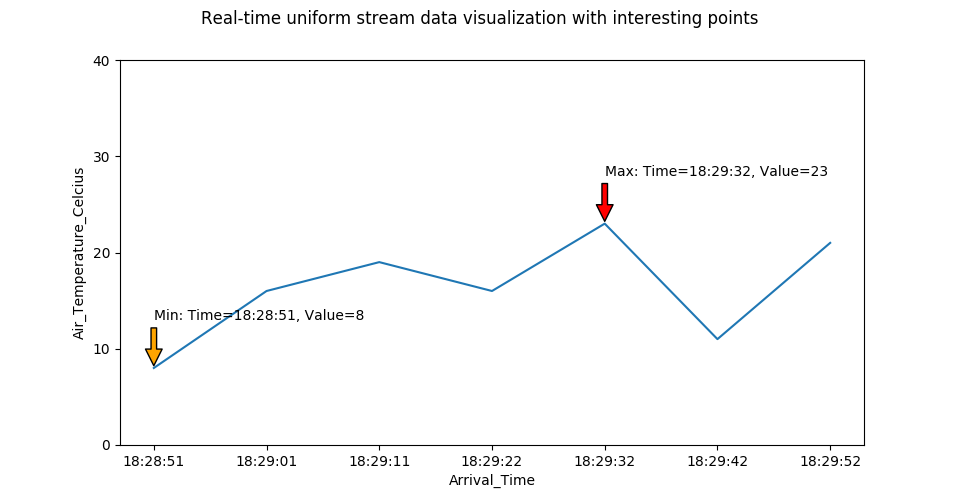

In [ ]:
topic = "vic_fire_producer"


def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:

        _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=100000, # stop iteration if no message after 10 sec
                                   #auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['127.0.0.1:9092'],
                                   api_version=(0, 10))
        
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.6
        height = 5
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization') # giving figure a title
        ax.set_xlabel('Arrival_Time')
        ax.set_ylabel('Air_Temperature_Celcius')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,20,40,60,80,100])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        for message in consumer:
            data = str(message.value.decode('utf-8'))
            data = eval(data)
            if data['Sender_ID'] != 1:
                continue
            else:
                x.append(dt.datetime.now().strftime("%X")) # there is no much different if we use 'Created_time'
                y.append(int(data['Air_Temperature_Celcius']))
            
            # we start plotting when we have more than 6 data points
            if len(y) > 6 :
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Arrival_Time')
                ax.set_ylabel('Air_Temperature_Celcius')
                ax.set_ylim(0,40) 
                ax.set_yticks([0,10,20,30,40])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                x.pop(0) # removing the item in the first position
                y.pop(0)
                    
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)

***2. Map visualization***

This map shows the fire locations as markers and displays detailed information
such as air temperature, surface temperature, relative humidity and
confidence with the marker tooltip. 
Folium package will be used for map visualization.

In [23]:
# connect to the db
client = MongoClient() 
db = client.skill_demo_db 
collection = db.vic_fire_collection

In [5]:
# initial the map
m = folium.Map(location=[-36.5000, 145.0000], zoom_start = 7, title = 'Fires in VIC')

In [6]:
# Get the information from db
search_result = collection.find({})

# store the location and information in two lists
location = []
info = []
for x in search_result:
    if len(x['Hotspot']) > 0:
        for i in range(len(x['Hotspot'])):
            location.append([float(x['Hotspot'][i]['Latitude']),
                             float(x['Hotspot'][i]['Longitude'])])
            info.append(str('Air_Temperature(Celcius): ' + str(x['Air_Temperature_Celcius']) + '<br>' +
                            'Surface_Temperature(Celcius): ' + str(x['Hotspot'][i]['Surface_Temperature_Celcius']) + '<br>' +
                            'Relative_Humidity: ' + str(x['Relative_Humidity']) + '<br>' +
                            'Confidence: ' + str(x['Hotspot'][i]['Confidence'])
                           )
                       )

In [7]:
# insert the marker
for i in range(len(location)):
    folium.Marker(location[i],tooltip = info[i]).add_to(m)

In [8]:
m